In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Choose the "true" parameters.
a_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = a_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [119]:
a_true = 3
b_true = 1
f_true = 0

y = np.array([13.670715  , 13.00907957,  8.76378314, 13.13024857, 15.12503714,
       10.43840114, 12.51278414, 25.91175286, 12.048953  , 21.48516571,
       15.05931571, 11.30904171,  8.02345429, 19.57128286, 14.68866857,
       21.10748143,  9.41893814,  9.42336529])
x = np.array([3.93972874, 4.0615619 , 2.54479024, 4.4241397 , 4.22959509,
       2.88491448, 3.47106306, 7.79552077, 3.20530062, 6.73209673,
       3.81202736, 3.03387392, 2.21457984, 4.62797221, 4.89312897,
       4.73371918, 2.93602719, 2.95701954])
yerr = np.array([0.96772687, 2.902353  , 0.4738192 , 1.10841076, 1.57950629,
       1.31237573, 1.28320997, 2.40376829, 1.79073671, 2.00547286,
       2.40488286, 3.21252757, 1.50793286, 3.46969629, 3.26611214,
       3.50438729, 1.07807123, 1.37095556])

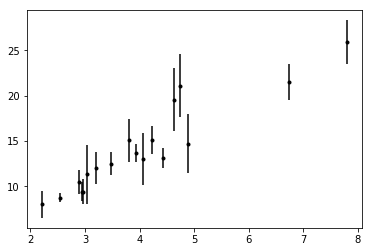

In [120]:
# Plot these dots
fig, ax=plt.subplots(1,1)
plt.errorbar(x, y, yerr=yerr, fmt='.k')
plt.show()

## Least Square Method

In [121]:
# Least Square Method
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, a_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

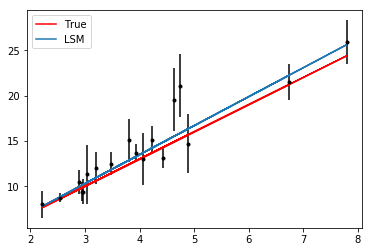

In [122]:
# Plot these dots
fig, ax=plt.subplots(1,1)
plt.errorbar(x, y, yerr=yerr, fmt='.k')
plt.plot(x, a_true*x+b_true, 'r', label='True')
plt.plot(x, a_ls*x+b_ls, '-', label='LSM')
plt.legend()
plt.show()

## Minimzing Likelihood Method

In [123]:
def model(theta, x):
    return theta[0]*x+theta[1]

def lnLikelihood(theta, x, y, yerr):
    a, b, lnf = theta
    model_value = model(theta, x)
    inv = 1/(yerr**2 + (model_value**2 * np.exp(2*lnf)))
    inv = inv/(2*np.pi)
    return -0.5*np.sum(inv*(model_value-y)**2)+0.5*np.sum(np.log(inv))

def lnPrior(theta):
    a, b, lnf = theta
    if -5<a<5 and -5<b<5 and -10<lnf<1:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, yerr):
    prior = lnPrior(theta)
    if ~np.isfinite(prior):
        return -np.inf
    return prior + lnLikelihood(theta, x, y, yerr)

import scipy.optimize as op
# We are MAXIMIZING lnProb, i.e. MINIMIZING -lnProb, 
#so for convenience we use lambda to define a temporary function nll.
nll = lambda *args: -lnProb(*args)
result = op.minimize(nll, [a_true, b_true, 0], args=(x, y, yerr))
a_ml, b_ml, lnf_ml = result["x"]
print(result['x'])

[ 3.19194813  0.72835959 -9.98823117]


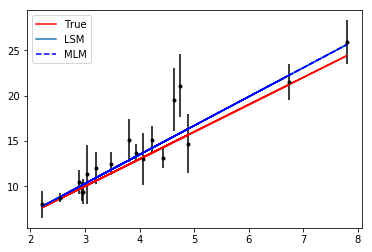

In [124]:
# Plot these dots
fig, ax=plt.subplots(1,1)
plt.errorbar(x, y, yerr=yerr, fmt='.k')
plt.plot(x, a_true*x+b_true, 'r', label='True')
plt.plot(x, a_ls*x+b_ls, '-', label='LSM')
plt.plot(x, a_ml*x+b_ml, 'b--', label='MLM')
plt.legend()
plt.show()

## MCMC

In [125]:
ndim, nwalkers = 3, 100
pos = [[a_ml, b_ml, lnf_ml] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, args=(x, y, yerr))
step = 500
res = sampler.run_mcmc(pos, step)

In [126]:
samples = sampler.chain[:,-300:,:].reshape((-1,ndim))

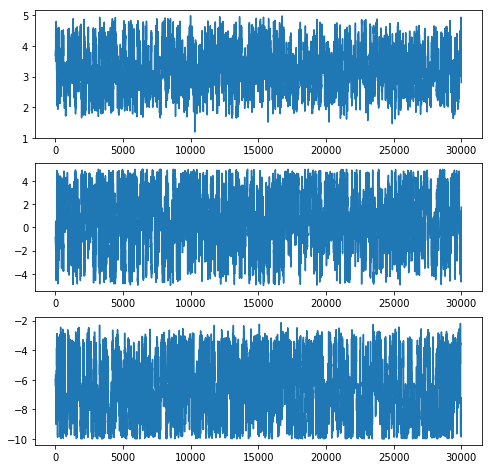

In [127]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((3,1),(0,0))
plt.plot(samples[:,0])
ax2 = plt.subplot2grid((3,1),(1,0))
plt.plot(samples[:,1])
ax3 = plt.subplot2grid((3,1),(2,0))
plt.plot(samples[:,2])
plt.show()

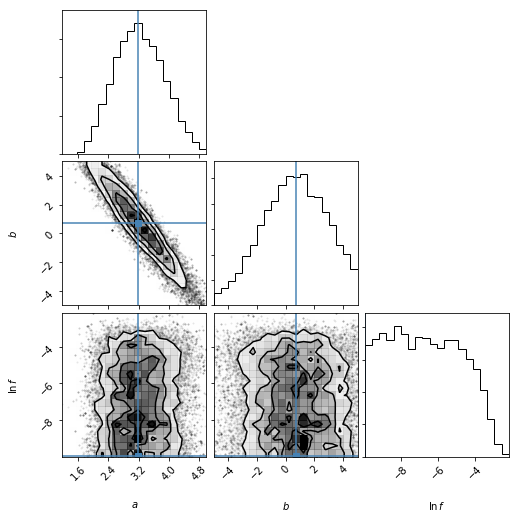

In [128]:
import corner
fig = corner.corner(samples, labels=["$a$", "$b$", "$\ln\,f$"],
                      truths=[a_ml, b_ml, lnf_ml])

<ErrorbarContainer object of 3 artists>

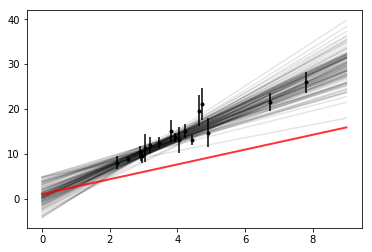

In [130]:
xl = np.array([0, 9])
for a, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, a*xl+b, color="k", alpha=0.1)

plt.plot(xl, 1.65*xl+1.04, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")

In [131]:
samples[:, 2] = np.exp(samples[:, 2])
a_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [132]:
print(a_mcmc, b_mcmc, f_mcmc)

(3.2008413219286562, 0.6903961599128614, 0.6395097021696086) (0.6475084211806524, 2.264429146588511, 2.321468601524075) (0.0011259464607663488, 0.009771611889026026, 0.000998790091817749)
